In [1]:
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import plotly.express as px
import pygal
from pygal.style import Style, LightGreenStyle, DarkGreenStyle
from IPython.display import SVG, HTML, display
import folium
import emoji
import re
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
%matplotlib inline

# Loading data, demojizing, creating new column

In [2]:
comments=pd.read_csv('NBA_Comments')

comments.drop(columns='Unnamed: 0', inplace=True)

all_comments=' '.join(comments['Comment'].astype(str))

def substitute_emojis_with_description(comment):
    substituted_comment = emoji.demojize(comment)
    plain_words = re.sub(r':|_', ' ', substituted_comment)
    return plain_words

for index, row in comments.iterrows():
    
    comments.at[index, 'Comment']=substitute_emojis_with_description(row['Comment'])
    
    comments.at[index, 'Video Title']=substitute_emojis_with_description(row['Video Title'])

comments['All']=comments['Video Title']+comments['Comment']

comments.head()

Video Title           User Name  \
0  Can Steph ace this Curry Quiz?  thinking face ...         @needatudor   
1  Can Steph ace this Curry Quiz?  thinking face ...              @5TXKA   
2  Can Steph ace this Curry Quiz?  thinking face ...  @JoselinRintharamy   
3  Can Steph ace this Curry Quiz?  thinking face ...    @TinaHutchinson1   
4  Can Steph ace this Curry Quiz?  thinking face ...       @EnosPatchala   

                                             Comment  \
0                                   Man doesn’t miss   
1                                     All these bots   
2                  What stimulates you? green heart    
3  I watch your channel with pleasure. Your video...   
4  How do you approach making important decisions...   

                                                 All  
0  Can Steph ace this Curry Quiz?  thinking face ...  
1  Can Steph ace this Curry Quiz?  thinking face ...  
2  Can Steph ace this Curry Quiz?  thinking face ...  
3  Can Steph ace this Curry Quiz?  thinking face ...  
4  Can Steph ace this Curry Quiz?  thinking face ...

In [3]:
round(comments['Comment'].str.len().mean(), 2)

96.86

# Comment sentiment analysis

In [4]:
sid = SentimentIntensityAnalyzer()

pos, neg, neu, compound, pol, sub, length = [], [], [], [], [], [], []

sentiments = []

for index, row in comments.iterrows():
    
    sentiment_scores = sid.polarity_scores(row['Comment'])
    
    pos.append(sentiment_scores['pos'])
    
    neg.append(sentiment_scores['neg'])
    
    neu.append(sentiment_scores['neu'])
    
    compound.append(sentiment_scores['compound'])
    
    blob = TextBlob(row['Comment'])
    
    pol.append(blob.subjectivity)
    
    sub.append(blob.polarity)
    
    length.append(len(row['Comment']))
    
comments['Positivity']=pos

comments['Negativity']=neg

comments['Neutrality']=neu

comments['Compoundness']=compound

comments['Polarity']=pol

comments['Subjectivity']=sub

comments['Length']=length

comments

Video Title             User Name  \
0     Can Steph ace this Curry Quiz?  thinking face ...           @needatudor   
1     Can Steph ace this Curry Quiz?  thinking face ...                @5TXKA   
2     Can Steph ace this Curry Quiz?  thinking face ...    @JoselinRintharamy   
3     Can Steph ace this Curry Quiz?  thinking face ...      @TinaHutchinson1   
4     Can Steph ace this Curry Quiz?  thinking face ...         @EnosPatchala   
...                                                 ...                   ...   
4889  BIG-TIME Block By Victor Wembanyama!  eyes  | ...       @that_guy_aidan   
4890  BIG-TIME Block By Victor Wembanyama!  eyes  | ...        @DaOutsider_Tv   
4891  BIG-TIME Block By Victor Wembanyama!  eyes  | ...       @jaehwanlee4138   
4892  BIG-TIME Block By Victor Wembanyama!  eyes  | ...  @Alexcarusohasagyatt   
4893  BIG-TIME Block By Victor Wembanyama!  eyes  | ...      @user-bt2ql6mz1v   

                                                Comment  \
0                                      Man doesn’t miss   
1                                        All these bots   
2                     What stimulates you? green heart    
3     I watch your channel with pleasure. Your video...   
4     How do you approach making important decisions...   
...                                                 ...   
4889                                  Such a clean swat   
4890  Ja is not used to be guarded by other people b...   
4891                                       justice wins   
4892                                                Pin   
4893                                       crying face    

                                                    All  Positivity  \
0     Can Steph ace this Curry Quiz?  thinking face ...       0.000   
1     Can Steph ace this Curry Quiz?  thinking face ...       0.000   
2     Can Steph ace this Curry Quiz?  thinking face ...       0.333   
3     Can Steph ace this Curry Quiz?  thinking face ...       0.258   
4     Can Steph ace this Curry Quiz?  thinking face ...       0.205   
...                                                 ...         ...   
4889  BIG-TIME Block By Victor Wembanyama!  eyes  | ...       0.574   
4890  BIG-TIME Block By Victor Wembanyama!  eyes  | ...       0.158   
4891  BIG-TIME Block By Victor Wembanyama!  eyes  | ...       1.000   
4892  BIG-TIME Block By Victor Wembanyama!  eyes  | ...       0.000   
4893  BIG-TIME Block By Victor Wembanyama!  eyes  | ...       0.000   

      Negativity  Neutrality  Compoundness  Polarity  Subjectivity  Length  
0          0.444       0.556       -0.1531    0.0000      0.000000      16  
1          0.000       1.000        0.0000    0.0000      0.000000      14  
2          0.000       0.667        0.2500    0.3000     -0.200000      33  
3          0.000       0.742        0.7650    0.6000      0.700000     128  
4          0.000       0.795        0.2023    1.0000      0.400000      59  
...          ...         ...           ...       ...           ...     ...  
4889       0.000       0.426        0.4019    0.6000      0.183333      17  
4890       0.000       0.842        0.6486    0.4875      0.137500     122  
4891       0.000       0.000        0.7964    0.2000      0.300000      12  
4892       0.000       1.000        0.0000    0.0000      0.000000       3  
4893       0.756       0.244       -0.4767    0.6000     -0.200000      13  

[4894 rows x 11 columns]

# Loading teams and players data

In [5]:
nba_teams_variations = {
    "Atlanta Hawks": ["hawks", "atl hawks", "atlanta", " atl "],
    "Boston Celtics": ["celtics", "boston", "bos celtics", " bos "],
    "Brooklyn Nets": ["nets", "bkn nets", "brooklyn", "bkn"],
    "Charlotte Hornets": ["hornets", "charlotte", "cha hornets", " cha "],
    "Chicago Bulls": ["bulls", "chicago", "chi bulls", " chi "],
    "Cleveland Cavaliers": ["cavaliers", "cavs", "cleveland", "cle cavs", " cle "],
    "Dallas Mavericks": ["mavericks", "dallas", "dal mavericks", " dal "],
    "Denver Nuggets": ["nuggets", "denver", "den nuggets", " den "],
    "Detroit Pistons": ["pistons", "detroit", "det pistons", " det "],
    "Golden State Warriors": ["warriors", "gsw", "golden state", "gsw warriors"],
    "Houston Rockets": ["rockets", "houston", "hou rockets", " hou "],
    "Indiana Pacers": ["pacers", "indiana", "ind pacers", " ind "],
    "LA Clippers": ["clippers", " lac ", "la clips"],
    "Los Angeles Lakers": ["lakers", " lal ", "la lakers", "lal lakers"],
    "Memphis Grizzlies": ["grizzlies", "memphis", "mem grizzlies", " mem "],
    "Miami Heat": ["heat", "miami", "mia heat", " mia "],
    "Milwaukee Bucks": ["bucks", "milwaukee", "mil bucks", " mil "],
    "Minnesota Timberwolves": ["timberwolves", "minnesota", "wolves", "min wolves", " min "],
    "New Orleans Pelicans": ["pelicans", "new orleans", "nop pelicans", " nop "],
    "New York Knicks": ["knicks", "ny knicks", "new york", " nyk ", " ny "],
    "Oklahoma City Thunder": ["thunder", "okc thunder", " okc ", "okc thunder"],
    "Orlando Magic": ["magic", "orlando", "orl magic", " orl "],
    "Philadelphia 76ers": ["76ers", "philadelphia", "phi 76ers", " phi "],
    "Phoenix Suns": ["suns", "phoenix", "phx suns", " phx "],
    "Portland Trail Blazers": ["trail blazers", "portland", "por blazers", " por "],
    "Sacramento Kings": ["kings", "sacramento", "sac kings", " sac "],
    "San Antonio Spurs": ["spurs", "san antonio", "sa spurs", " sa "],
    "Toronto Raptors": ["raptors", "toronto", "tor raptors", " tor "],
    "Utah Jazz": ["jazz", "utah", "uta jazz", " uta "],
    "Washington Wizards": ["wizards", "washington", "was wizards", "dc wizards", " wiz "]
}

In [6]:
nba_players_variations = {
    "LeBron James": ["lebron james", "lebron", "lbj", "king james"],
    "Kevin Durant": ["kevin durant", " kd ", "durant"],
    "Stephen Curry": ["stephen curry", "steph curry", "curry", "steph"],
    "Giannis Antetokounmpo": ["giannis antetokounmpo", "giannis", "antetokounmpo"],
    "James Harden": ["james harden", "harden", "the beard"],
    "Kawhi Leonard": ["kawhi leonard", "kawhi", "klaw"],
    "Anthony Davis": ["anthony davis", " ad ", "a.d."],
    "Luka Doncic": ["luka doncic", "luka", "doncic"],
    "Damian Lillard": ["damian lillard", "lillard", "dame"],
    "Joel Embiid": ["joel embiid", "embiid", "the process"],
    "Kyrie Irving": ["kyrie irving", "kyrie", "uncle drew"],
    "Russell Westbrook": ["russell westbrook", "westbrook", "brodie"],
    "Nikola Jokic": ["nikola jokic", "jokic", "joker"],
    "Paul George": ["paul george", " pg ", "playoff p"],
    "Jimmy Butler": ["jimmy butler", "butler"],
    "Devin Booker": ["devin booker", "booker"],
    "Zion Williamson": ["zion williamson", "zion"],
    "Karl-Anthony Towns": ["karl-anthony towns", " kat ", "towns"],
    "Jayson Tatum": ["jayson tatum", "tatum"],
    "Trae Young": ["trae young", "young"],
    "Khris Middleton": ["khris middleton", "middleton"],
    "Bam Adebayo": ["bam adebayo", "adebayo", "bam"],
    "Donovan Mitchell": ["donovan mitchell", "mitchell", "spida"],
    "Chris Paul": ["chris paul", "cp3", "cp"],
    "De'Aaron Fox": ["de'aaron fox", "fox"],
    "Ja Morant": ["ja morant", "morant"],
    "Brandon Ingram": ["brandon ingram", "ingram"],
    "Julius Randle": ["julius randle", "randle"],
    "LaMelo Ball": ["lamelo ball", "lamelo"],
    "Jaren Jackson Jr.": ["jaren jackson jr.", "jaren jackson", "jackson jr."],
    "DeMar DeRozan": ["demar derozan", "derozan", "demar"],
    "Ben Simmons": ["ben simmons", "simmons"],
    "Jamal Murray": ["jamal murray", "murray"],
    "Victor Wembanyama": ['wemby', 'wembanyama'],
    "Deandre Ayton": ["deandre ayton", "ayton"],
    "Zach LaVine": ["zach lavine", "lavine"],
    "John Wall": ["john wall", "wall"],
    "Andre Drummond": ["andre drummond", "drummond"],
    "Kristaps Porzingis": ["kristaps porzingis", "porzingis"],
    "Tobias Harris": ["tobias harris", "harris"],
    "Myles Turner": ["myles turner", "turner"],
    "D'Angelo Russell": ["d'angelo russell", "russell"],
    "Kyle Lowry": ["kyle lowry", "lowry"],
    "Andrew Wiggins": ["andrew wiggins", "wiggins"],
    "Michael Porter Jr.": ["michael porter jr.", "porter jr.", "michael porter"],
    "Jrue Holiday": ["jrue holiday", "holiday"],
    "Shai Gilgeous-Alexander": ["shai gilgeous-alexander", "shai alexander", "gilgeous-alexander"],
    "Chet Holmgren": ['chet holmgren', 'chet'],
    "Jalen Williams": ['jalen williams', 'jdub']
}

# Adding tags to comments

In [7]:
teams_lists=[]

players_lists=[]

for index, row in comments.iterrows():
    
    teams=[]
    
    for team in nba_teams_variations.keys():
        
        for variation in nba_teams_variations[team]:
            
            if variation in row["All"].lower():
                
                teams.append(team)
                
                break
                
    teams_lists.append(teams)
    
for index, row in comments.iterrows():
    
    players=[]
    
    for player in nba_players_variations.keys():
        
        for variation in nba_players_variations[player]:
            
            if variation in row["All"].lower():
                
                players.append(player)
                
                break
                
    players_lists.append(players)    
    
comments["Teams"]=teams_lists

comments["Players"]=players_lists

comments.head()

Video Title           User Name  \
0  Can Steph ace this Curry Quiz?  thinking face ...         @needatudor   
1  Can Steph ace this Curry Quiz?  thinking face ...              @5TXKA   
2  Can Steph ace this Curry Quiz?  thinking face ...  @JoselinRintharamy   
3  Can Steph ace this Curry Quiz?  thinking face ...    @TinaHutchinson1   
4  Can Steph ace this Curry Quiz?  thinking face ...       @EnosPatchala   

                                             Comment  \
0                                   Man doesn’t miss   
1                                     All these bots   
2                  What stimulates you? green heart    
3  I watch your channel with pleasure. Your video...   
4  How do you approach making important decisions...   

                                                 All  Positivity  Negativity  \
0  Can Steph ace this Curry Quiz?  thinking face ...       0.000       0.444   
1  Can Steph ace this Curry Quiz?  thinking face ...       0.000       0.000   
2  Can Steph ace this Curry Quiz?  thinking face ...       0.333       0.000   
3  Can Steph ace this Curry Quiz?  thinking face ...       0.258       0.000   
4  Can Steph ace this Curry Quiz?  thinking face ...       0.205       0.000   

   Neutrality  Compoundness  Polarity  Subjectivity  Length Teams  \
0       0.556       -0.1531       0.0           0.0      16    []   
1       1.000        0.0000       0.0           0.0      14    []   
2       0.667        0.2500       0.3          -0.2      33    []   
3       0.742        0.7650       0.6           0.7     128    []   
4       0.795        0.2023       1.0           0.4      59    []   

           Players  
0  [Stephen Curry]  
1  [Stephen Curry]  
2  [Stephen Curry]  
3  [Stephen Curry]  
4  [Stephen Curry]

In [8]:
comments['Teams'].apply(len).mean()

1.5839803841438496

In [9]:
comments['Players'].apply(len).mean()

0.4959133633020025

# New datasets

In [10]:
teams_sentiments={}

for team in nba_teams_variations.keys():
    
    sentiments=[]
    
    for index, row in comments.iterrows():
        
        if team in row["Teams"]:
            
            sentiments.append([row['Positivity'], row['Negativity'], row['Neutrality'], row['Compoundness'], row['Polarity'], row['Subjectivity'], row['Length']])
            
    teams_sentiments[team]=sentiments
    
for team, sentiments in teams_sentiments.items():
    
    transposed = zip(*sentiments)

    averages = [sum(values) / len(values) for values in transposed]
    
    teams_sentiments[team]=averages
    
teams_sentiments = pd.DataFrame.from_dict(teams_sentiments, orient='index')

teams_sentiments.columns=comments.columns[4:11]

teams_sentiments

Positivity  Negativity  Neutrality  Compoundness  \
Atlanta Hawks             0.183903    0.113911    0.702153      0.170082   
Boston Celtics            0.168772    0.085918    0.745302      0.218628   
Brooklyn Nets             0.146820    0.150170    0.699923      0.066522   
Charlotte Hornets         0.141912    0.142118    0.711078      0.043486   
Chicago Bulls             0.173136    0.095631    0.726379      0.211020   
Cleveland Cavaliers       0.170273    0.184545    0.645182      0.066084   
Dallas Mavericks          0.149464    0.101810    0.748690      0.133906   
Denver Nuggets            0.188038    0.074885    0.737000      0.384696   
Detroit Pistons           0.175711    0.128205    0.696052      0.149875   
Golden State Warriors     0.203583    0.096461    0.695604      0.220218   
Houston Rockets           0.140933    0.142600    0.716467      0.061322   
Indiana Pacers            0.163050    0.116541    0.720421      0.164958   
LA Clippers               0.173549    0.088302    0.738131      0.241715   
Los Angeles Lakers        0.160824    0.132699    0.706481      0.137305   
Memphis Grizzlies         0.182271    0.094786    0.722943      0.205520   
Miami Heat                0.165397    0.135509    0.699100      0.138163   
Milwaukee Bucks           0.161714    0.115496    0.722806      0.160596   
Minnesota Timberwolves    0.171595    0.112517    0.715897      0.200251   
New Orleans Pelicans      0.161300    0.142778    0.695950      0.123496   
New York Knicks           0.194141    0.086052    0.712393      0.277590   
Oklahoma City Thunder     0.172567    0.100405    0.727007      0.214124   
Orlando Magic             0.179846    0.101922    0.716127      0.169259   
Philadelphia 76ers        0.163533    0.097620    0.738818      0.199098   
Phoenix Suns              0.167625    0.086266    0.746099      0.232112   
Portland Trail Blazers    0.161382    0.085214    0.753405      0.193540   
Sacramento Kings          0.146148    0.130759    0.720598      0.091334   
San Antonio Spurs         0.171758    0.094388    0.733855      0.169359   
Toronto Raptors           0.190158    0.090049    0.719778      0.243359   
Utah Jazz                 0.178071    0.124724    0.697176      0.160336   
Washington Wizards        0.164117    0.187583    0.648300      0.049950   

                        Polarity  Subjectivity      Length  
Atlanta Hawks           0.369877      0.096401  154.403226  
Boston Celtics          0.342122      0.133469   98.686667  
Brooklyn Nets           0.319745      0.103597   96.563467  
Charlotte Hornets       0.356479      0.105129  107.392157  
Chicago Bulls           0.358902      0.134396  116.941748  
Cleveland Cavaliers     0.339722      0.073419  131.018182  
Dallas Mavericks        0.299541      0.122724   90.285714  
Denver Nuggets          0.467973      0.252166  314.769231  
Detroit Pistons         0.389448      0.045634   98.706827  
Golden State Warriors   0.389605      0.158158  111.760870  
Houston Rockets         0.215737      0.106890  109.111111  
Indiana Pacers          0.370891      0.154613  131.223140  
LA Clippers             0.397669      0.167905  122.552239  
Los Angeles Lakers      0.332266      0.123301  119.808896  
Memphis Grizzlies       0.356011      0.148335   97.026128  
Miami Heat              0.330545      0.131567  115.170178  
Milwaukee Bucks         0.362797      0.149056  130.879032  
Minnesota Timberwolves  0.344208      0.125638  135.750000  
New Orleans Pelicans    0.309712      0.108902  119.483333  
New York Knicks         0.361449      0.154980  116.511111  
Oklahoma City Thunder   0.358710      0.121234  116.541818  
Orlando Magic           0.387672      0.141585  105.522199  
Philadelphia 76ers      0.357388      0.170276  113.569343  
Phoenix Suns            0.395700      0.160492  117.961538  
Portland Trail Blazers  0.332110      0.119789   87.104046  
Sacramento Kings        0.355420      0.102631  107.728643  
San Antonio Spurs   

In [11]:
players_sentiments={}

for player in nba_players_variations.keys():
    
    sentiments=[]
    
    for index, row in comments.iterrows():
        
        if player in row["Players"]:
            
            sentiments.append([row['Positivity'], row['Negativity'], row['Neutrality'], row['Compoundness'], row['Polarity'], row['Subjectivity'], row['Length']])
            
    players_sentiments[player]=sentiments
    
for player, sentiments in players_sentiments.items():
    
    transposed = zip(*sentiments)

    averages = [sum(values) / len(values) for values in transposed]
    
    players_sentiments[player]=averages
    
players_sentiments = pd.DataFrame.from_dict(players_sentiments, orient='index')

players_sentiments.columns=comments.columns[4:11]

players_sentiments

Positivity  Negativity  Neutrality  Compoundness  \
LeBron James               0.145743    0.117632    0.736661      0.106539   
Kevin Durant               0.176383    0.087745    0.735830      0.275351   
Stephen Curry              0.199615    0.076708    0.723708      0.263149   
Giannis Antetokounmpo      0.149324    0.100971    0.749706      0.214753   
James Harden               0.172250    0.076458    0.751333      0.406825   
Kawhi Leonard              0.151262    0.086833    0.761917      0.250018   
Anthony Davis              0.180860    0.104953    0.714233      0.182381   
Luka Doncic                0.149332    0.065712    0.776236      0.179403   
Damian Lillard             0.153806    0.137333    0.708903      0.125317   
Joel Embiid                0.182819    0.079767    0.737371      0.263876   
Kyrie Irving               0.190955    0.095091    0.713955      0.253664   
Russell Westbrook          0.172222    0.072944    0.754833      0.340633   
Nikola Jokic               0.192286    0.017714    0.790000      0.511636   
Paul George                0.143911    0.084557    0.771506      0.179303   
Jimmy Butler               0.176643    0.215000    0.608357      0.144836   
Devin Booker               0.088462    0.071154    0.840462      0.100185   
Zion Williamson            0.121987    0.161244    0.716782      0.027785   
Karl-Anthony Towns         0.058333    0.196667    0.745000     -0.553867   
Jayson Tatum               0.145771    0.069286    0.784943      0.259469   
Trae Young                 0.212096    0.084327    0.703538      0.374179   
Khris Middleton            0.124000    0.160167    0.715833     -0.073433   
Bam Adebayo                0.157069    0.063138    0.779690      0.410241   
Donovan Mitchell           0.185250    0.165125    0.649875      0.254300   
Chris Paul                 0.040278    0.146167    0.813556     -0.208644   
De'Aaron Fox               0.160893    0.146179    0.692964      0.059682   
Ja Morant                  0.131218    0.106168    0.762642      0.087747   
Brandon Ingram             0.117778    0.188667    0.693556      0.062067   
Julius Randle              0.132231    0.090462    0.777308      0.222946   
LaMelo Ball                0.130400    0.191200    0.678400     -0.057180   
Jaren Jackson Jr.          0.137000    0.245000    0.618000     -0.074700   
DeMar DeRozan              0.070889    0.029111    0.900000      0.200833   
Ben Simmons                0.221000    0.225000    0.554000      0.047650   
Jamal Murray               0.159600    0.132350    0.708100      0.211675   
Victor Wembanyama          0.135407    0.095681    0.768905      0.114493   
Deandre Ayton              0.117250    0.190500    0.692250     -0.391875   
Zach LaVine                0.180800    0.037600    0.781600      0.319880   
John Wall                  0.043500    0.120500    0.836500     -0.260250   
Andre Drummond             0.049857    0.078000    0.872143      0.114629   
Kristaps Porzingis         0.162778    0.063556    0.773778      0.356078   
Tobias Harris              0.113857    0.280571    0.605571     -0.115886   
Myles Turner               0.074000    0.251833    0.674167     -0.083883   
D'Angelo Russell           0.274667    0.011667    0.713667      0.781367   
Kyle Lowry                 0.079000    0.315000    0.606000     -0.237400   
Andrew Wiggins             0.108083    0.079667    0.812250      0.314892   
Michael Porter Jr.         0.279500    0.069000    0.651500      0.658900   
Jrue Holiday               0.308591    0.103273    0.588227      0.458955   
Shai Gilgeous-Alexander    0.156134    0.063336    0.780537      0.205099   
Chet Holmgren              0.098179    0.103256    0.798513      0.120459   
Jalen Williams             0.088000    0.161857    0.750000     -0.146429   

                         Polarity  Subjectivity      Length  
LeBron James             0.298167      0.125399  136.631579  
Kevin Durant             0.428195      0.209216  1

# Top 5 and low 5 in each category

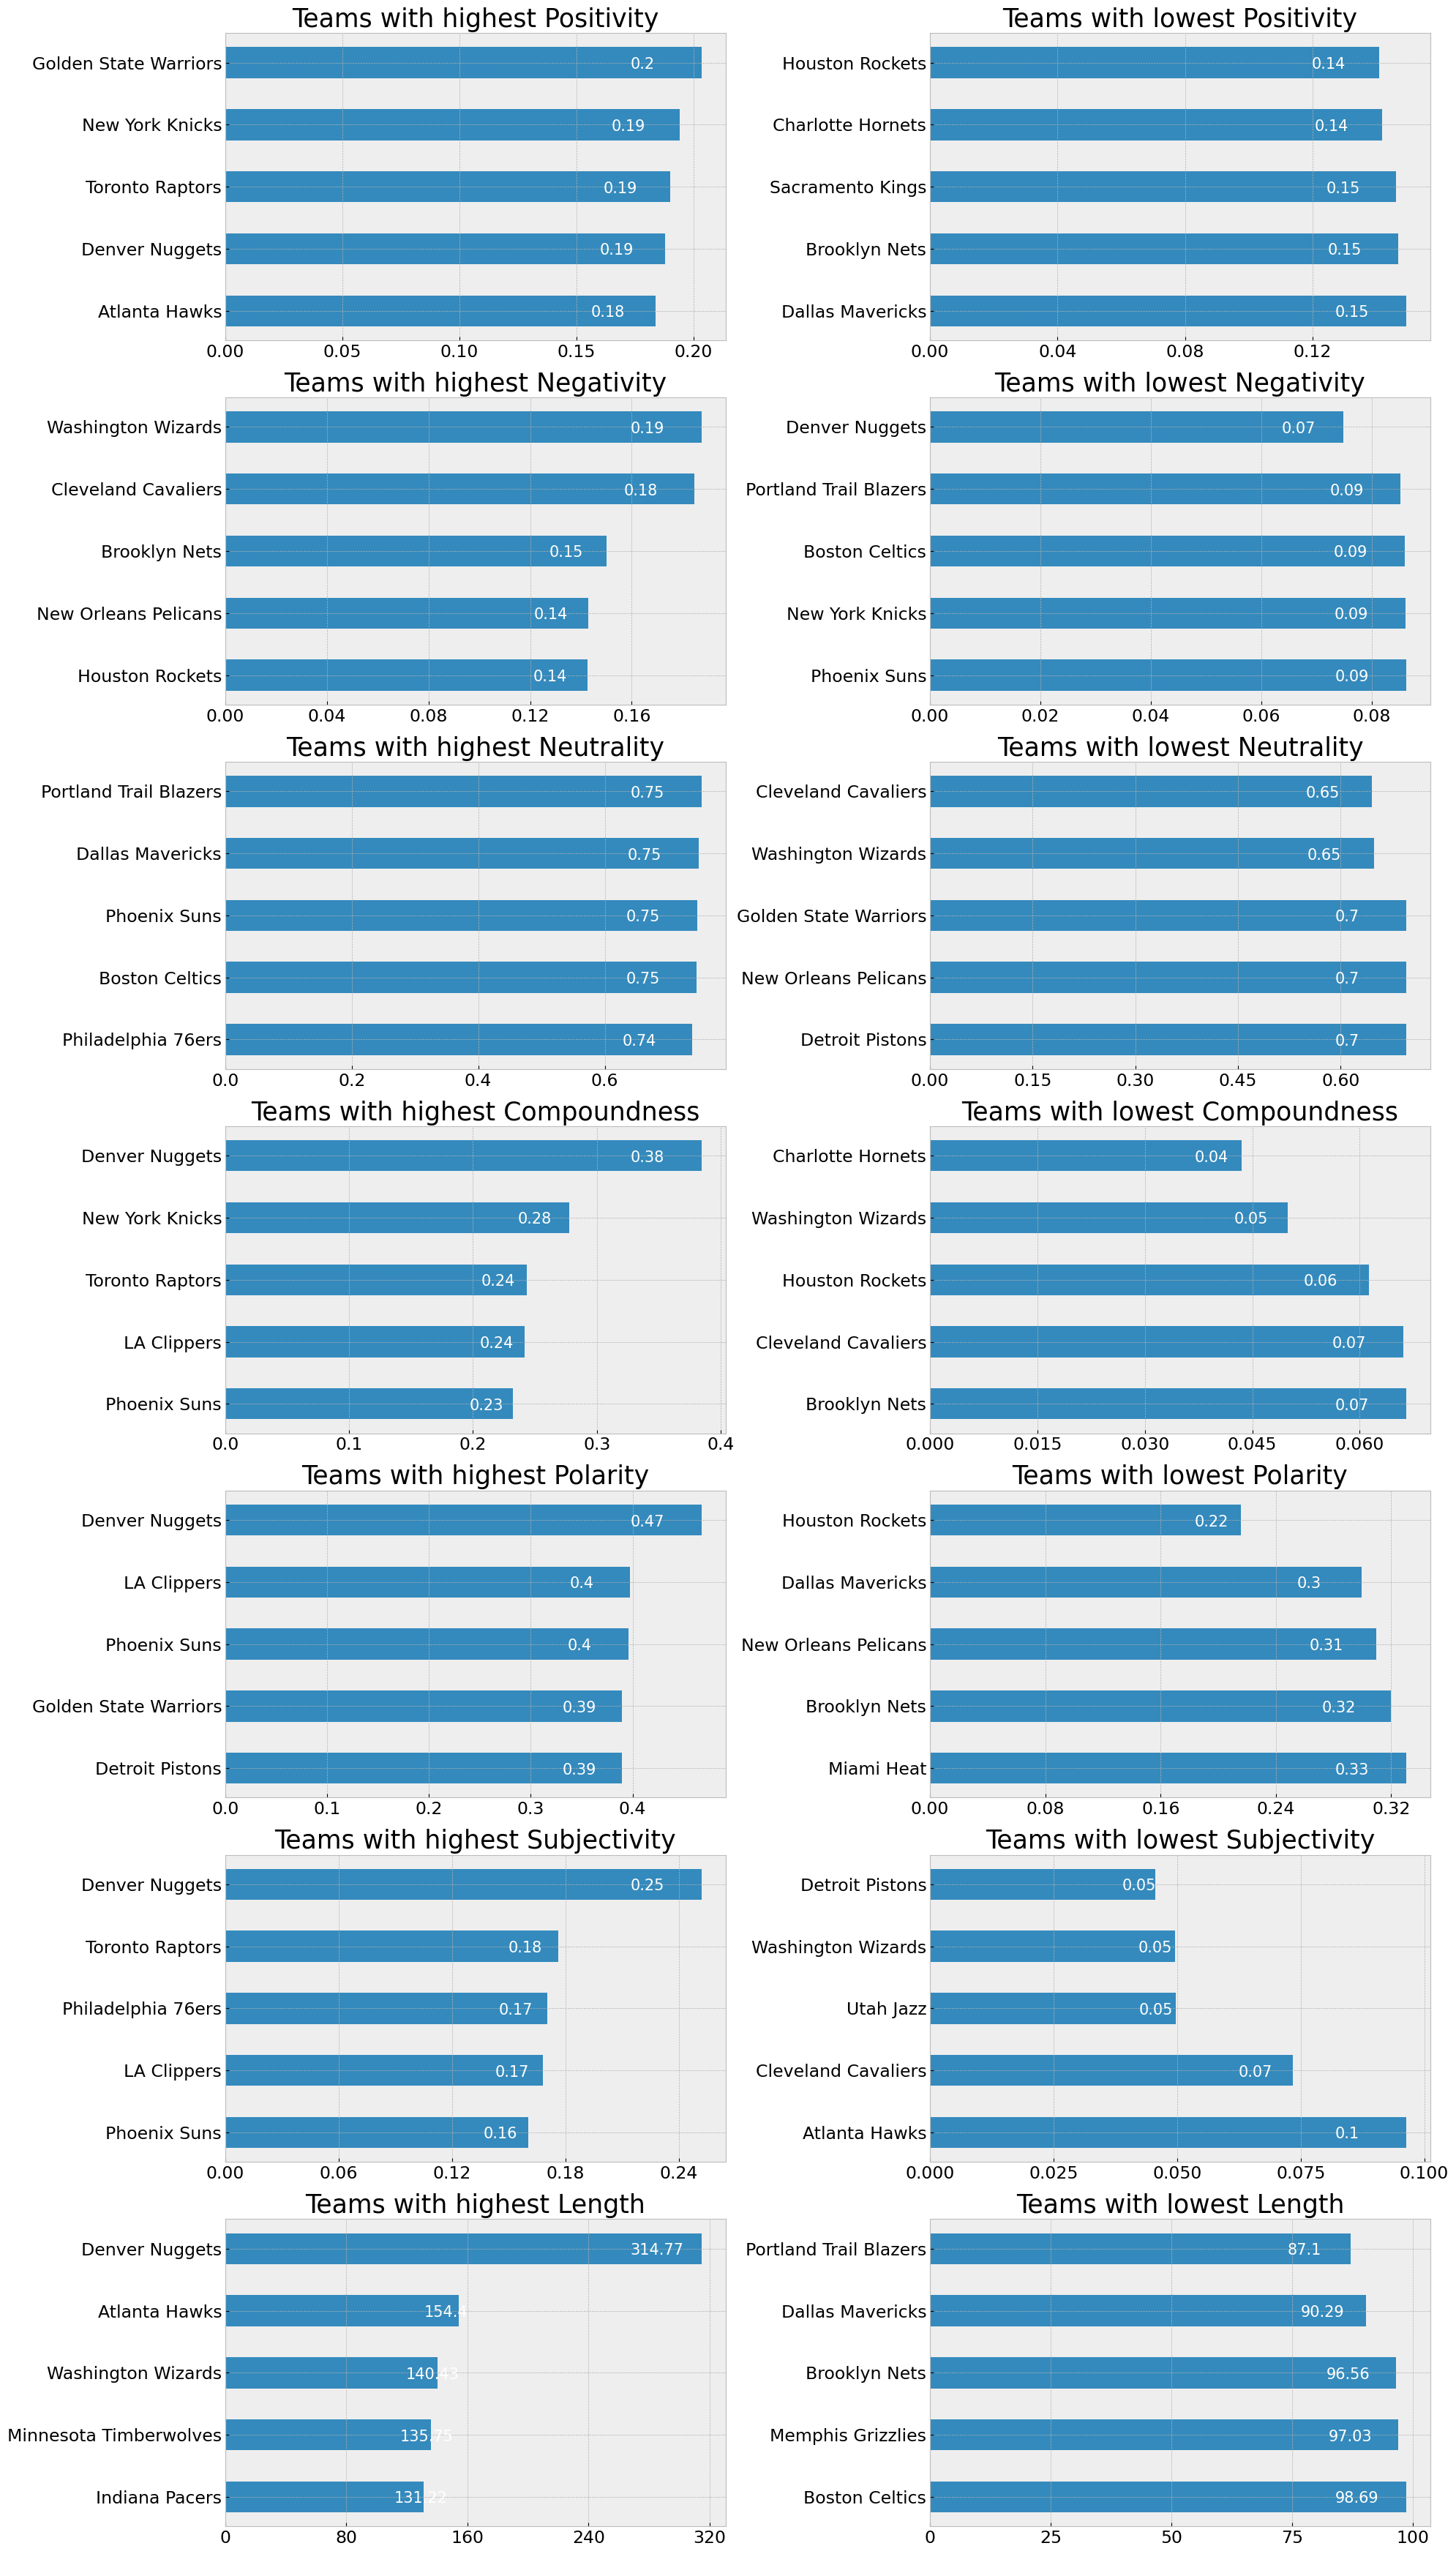

In [12]:
mpl.style.use(['bmh'])

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(20, 35))

ax=ax.flatten()

for index, column in enumerate(teams_sentiments.columns):
    
    top=teams_sentiments.sort_values(column, ascending=False).head()
    
    top=top.sort_values(column)
    
    top=top[column]
    
    down=teams_sentiments.sort_values(column).head()
    
    down=down.sort_values(column, ascending=False)
    
    down=down[column]
    
    ax[index*2].barh(top.index, top.values, height=0.5)
    
    ax[index*2].set_title(f"Teams with highest {column}", fontsize=25)
    
    ax[index*2].xaxis.set_major_locator(MaxNLocator(nbins=5))
    
    ax[index*2].tick_params(axis='both', which='major', labelsize=17)
    
    for index_1, value in enumerate(top):
    
        ax[index*2].annotate(round(value, 2), xy=(value*0.85, index_1-0.1), color='white', fontsize=15)
    
    ax[index*2+1].barh(down.index, down.values, height=0.5)
    
    ax[index*2+1].set_title(f"Teams with lowest {column}", fontsize=25)
    
    ax[index*2+1].xaxis.set_major_locator(MaxNLocator(nbins=5))
    
    ax[index*2+1].tick_params(axis='both', which='major', labelsize=17)
    
    for index_1, value in enumerate(down):
    
        ax[index*2+1].annotate(round(value, 2), xy=(value*0.85, index_1-0.1), color='white', fontsize=15)
        
plt.tight_layout()

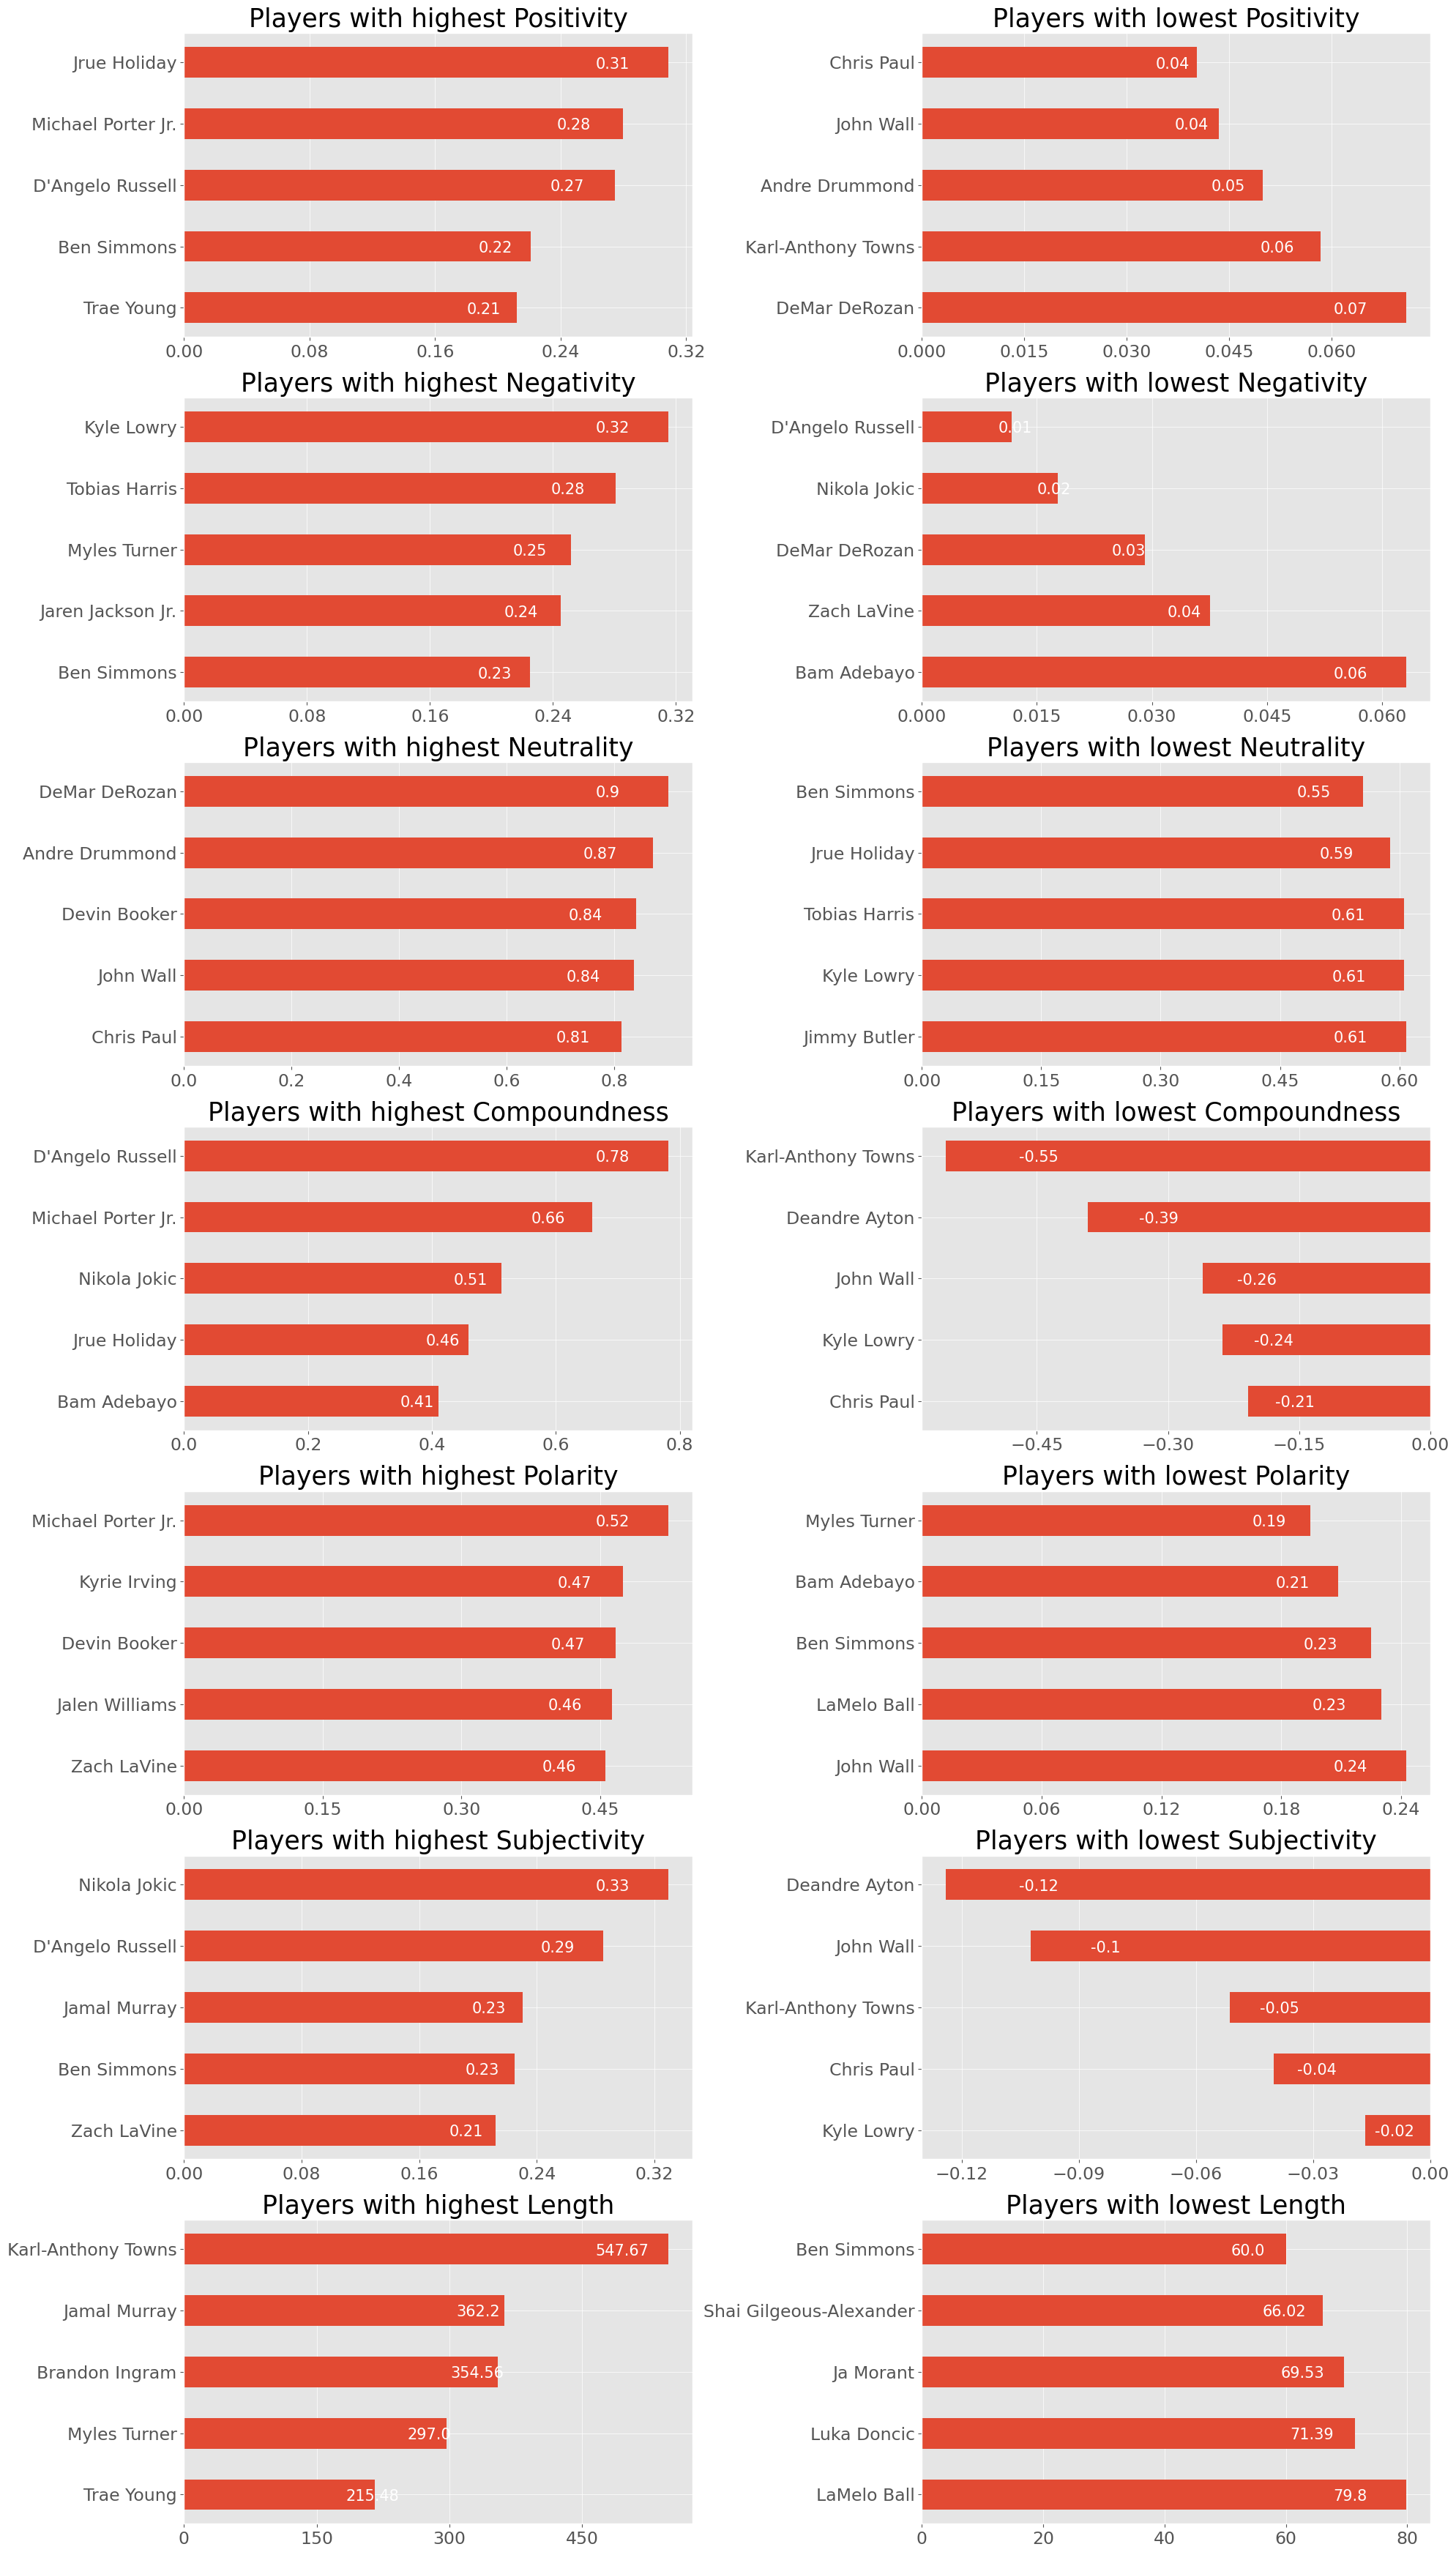

In [13]:
mpl.style.use(['ggplot'])

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(20, 35))

ax=ax.flatten()

for index, column in enumerate(players_sentiments.columns):
    
    top=players_sentiments.sort_values(column, ascending=False).head()
    
    top=top.sort_values(column)
    
    top=top[column]
    
    down=players_sentiments.sort_values(column).head()
    
    down=down.sort_values(column, ascending=False)
    
    down=down[column]
    
    ax[index*2].barh(top.index, top.values, height=0.5)
    
    ax[index*2].set_title(f"Players with highest {column}", fontsize=25)
    
    ax[index*2].xaxis.set_major_locator(MaxNLocator(nbins=5))
    
    ax[index*2].tick_params(axis='both', which='major', labelsize=17)
    
    for index_1, value in enumerate(top):
    
        ax[index*2].annotate(round(value, 2), xy=(value*0.85, index_1-0.1), color='white', fontsize=15)
    
    ax[index*2+1].barh(down.index, down.values, height=0.5)
    
    ax[index*2+1].set_title(f"Players with lowest {column}", fontsize=25)
    
    ax[index*2+1].xaxis.set_major_locator(MaxNLocator(nbins=5))
    
    ax[index*2+1].tick_params(axis='both', which='major', labelsize=17)
    
    for index_1, value in enumerate(down):
    
        ax[index*2+1].annotate(round(value, 2), xy=(value*0.85, index_1-0.1), color='white', fontsize=15)
        
plt.tight_layout()

# Heatmaps

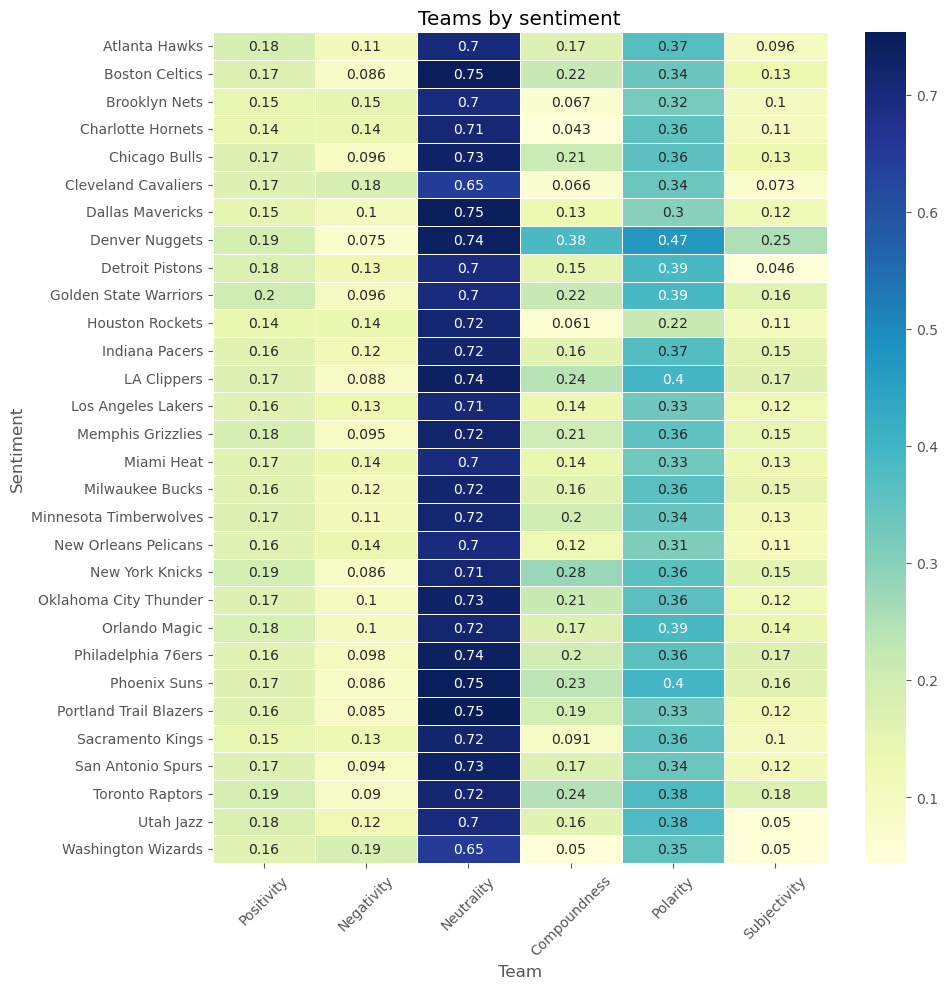

In [14]:
plt.figure(figsize=(10, 10))

sns.heatmap(teams_sentiments.iloc[:,:6], cmap='YlGnBu', annot=True, linewidths=.5)

plt.title('Teams by sentiment')

plt.xlabel('Team')

plt.ylabel('Sentiment')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

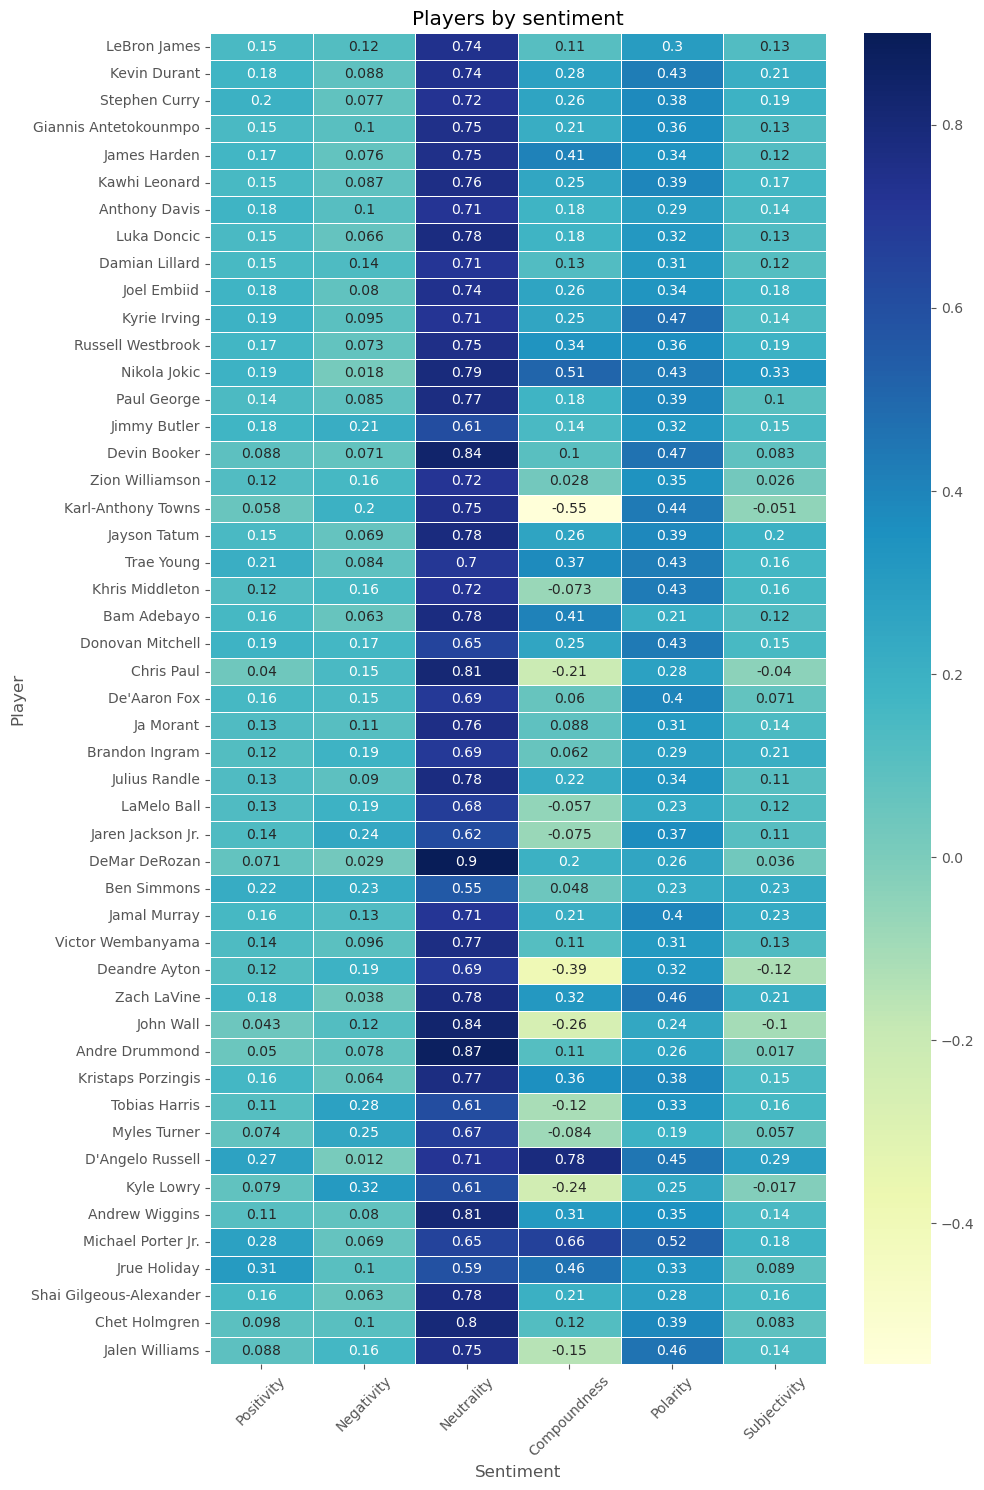

In [15]:
plt.figure(figsize=(10, 15))

sns.heatmap(players_sentiments.iloc[:,:6], cmap='YlGnBu', annot=True, linewidths=.5)

plt.title('Players by sentiment')

plt.xlabel('Sentiment')

plt.ylabel('Player')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

# Scatter plots

In [16]:
fig = px.scatter(teams_sentiments, x='Polarity', y='Subjectivity', text=list(teams_sentiments.index))

fig.show() 

In [17]:
fig = px.scatter(players_sentiments, x='Polarity', y='Subjectivity', text=list(players_sentiments.index))

fig.show()

# Direct comparisons

In [18]:
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

def galplot(chart):
    
    rendered_chart = chart.render(is_unicode=True)
    
    plot_html = base_html.format(rendered_chart=rendered_chart)

    display(HTML(plot_html))

In [19]:
Radar_Chart = pygal.Radar(style=LightGreenStyle)

stats=teams_sentiments.columns

teams=['Denver Nuggets', 'Oklahoma City Thunder', 'Milwaukee Bucks', 'Boston Celtics']

Radar_Chart.title = f'Radar Chart - {len(teams)} players comparison'

Radar_Chart.x_labels=stats

Radar_Chart.range = (0, 1)

teams_sentiments_norm=(teams_sentiments - teams_sentiments.min()) / (teams_sentiments.max() - teams_sentiments.min())

for team in teams:
    
    Radar_Chart.add(team, list(teams_sentiments_norm.loc[team])) #Adjusting lines 
    
galplot(Radar_Chart)

In [20]:
Radar_Chart = pygal.Radar(style=DarkGreenStyle)

stats=players_sentiments.columns

players=['LeBron James', 'Kevin Durant', 'Stephen Curry', 'Russell Westbrook']

Radar_Chart.title = f'Radar Chart - {len(players)} players comparison'

Radar_Chart.x_labels=stats

Radar_Chart.range = (0, 1)

players_sentiments_norm=(players_sentiments - players_sentiments.min()) / (players_sentiments.max() - players_sentiments.min())

for player in players:
    
    Radar_Chart.add(player, list(players_sentiments_norm.loc[player])) #Adjusting lines 
    
galplot(Radar_Chart)

# Map

In [21]:
locations = {
    'Team': list(teams_sentiments.index),
    'Latitude': [
        33.7572, 42.3662, 40.6826, 35.2269, 41.8807, 41.4965, 32.7903, 39.7392, 42.3314,
        37.8048, 29.7573, 39.7640, 34.0430, 34.0522, 35.1495, 25.7617, 43.0389, 44.9778,
        29.9489, 40.7505, 35.4634, 28.5383, 39.9526, 33.4484, 45.5200, 38.5816, 29.3561, 
        43.6532, 40.7601, 38.9072
    ],
    'Longitude': [
        -84.3963, -71.0621, -73.9743, -80.8433, -87.6742, -81.6882, -96.7652, -104.9903, -83.0458,
        -122.4010, -95.3698, -86.1555, -118.2673, -118.2440, -90.0490, -80.1918, -87.9065, -93.2650,
        -90.0813, -73.9934, -97.5164, -81.3792, -75.1652, -112.0740, -122.6750, -121.4950, -98.4876, 
        -79.3832, -111.8990, -77.0369
    ]}

locations=pd.DataFrame(locations)

In [22]:
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

In [23]:
stat="Positivity"

locations['Stat']=list(teams_sentiments[stat])

for index, row in locations.iterrows():
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=(row['Stat']**4)*10000,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"{row['Team']} - {round(row['Stat']*100, 2)}%"
        
    ).add_to(m)

m

# Wordmap

In [24]:
stopwords = set(STOPWORDS)

stops=['need', 'go', 'see', 'really', 'will', 's', 'still', 'getting', 'guy']
for stop in stops:
    stopwords.add(stop)


nba_mask = np.array(Image.open('pngwing.com.png'))

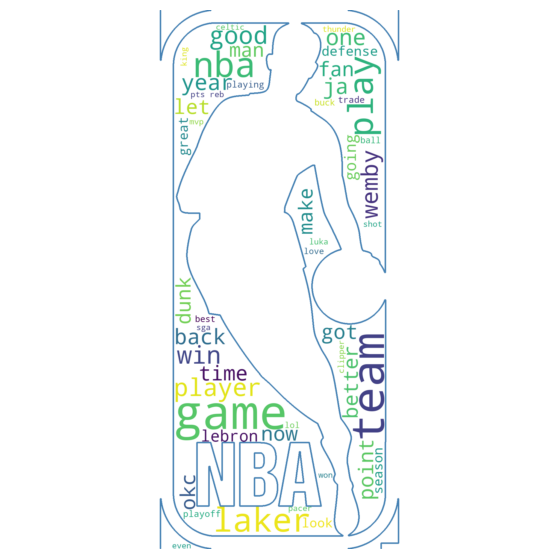

In [25]:
wordcloud = WordCloud(background_color='white', max_words=50, mask=nba_mask, stopwords=stopwords,
                        contour_width=5, contour_color='steelblue')

wordcloud.generate(all_comments.lower())

fig = plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()